In [ ]:
!pip install matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Simple utilities
def imdisp(im):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

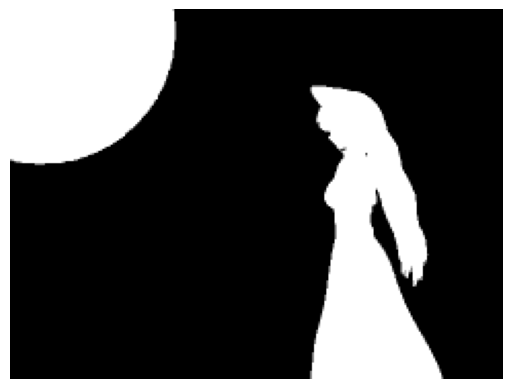

In [91]:
# Load image
image_gs = cv2.imread('frames/BadApple_3010.jpg', cv2.IMREAD_GRAYSCALE)
_, image = cv2.threshold(image_gs, 127 , 255, cv2.THRESH_BINARY)
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
imdisp(image)

Found 2 contours with lengths [471, 269].


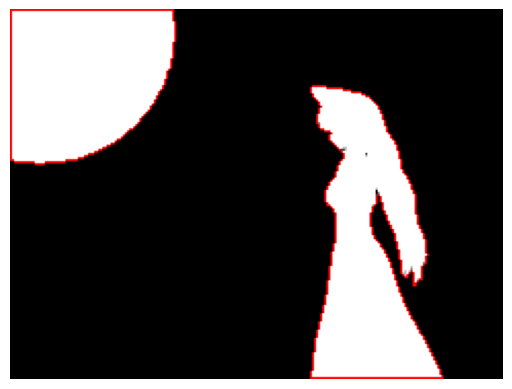

In [118]:
conts, hier = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
conts = [ i for i in conts if [0, 0] not in i or [179, 239] not in i ]
athresh = 10
conts = [ i for i in conts if cv2.contourArea(i) > athresh ]
print(f"Found {len(conts)} contours with lengths {[ len(i) for i in conts ]}.")
imdisp(cv2.drawContours(cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR), conts, -1, (0,0,255), 1))

In [147]:
deplsize = 40
depl = 179 - 20
def place_in_mosfet(xs):
    deplr = [ depl for _ in range(deplsize) ]
    return deplr + xs + deplr
total_width = 239 + (2 * deplsize)

In [133]:
def contour_to_lines(cont):
    contmap = {}
    for [[x, y]] in cont:
        if x not in contmap:
            contmap[x] = []
        contmap[x].append(y)
    rlines = [{}, {}]
    entrance, exit = None, None
    for x, ys in contmap.items():
        # Entrance:
        if entrance is None:
            entrance = (x, max(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, max(ys))
        if entrance is None:
            entrances = (x, min(ys))
        else:
            (prev_x, _) = entrance
            if x < prev_x:
                entrance = (x, min(ys))
        # Exit:
        if exit is None:
            exit = (x, max(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, max(ys))
        if exit is None:
            exits = (x, min(ys))
        else:
            (prev_x, _) = exit
            if x > prev_x:
                exit = (x, min(ys))
        # Normal:
        rlines[0][x] = max(ys)
        rlines[1][x] = min(ys)
    lines = [[], []]
    lasts = [ i for (_, i) in [entrance, entrance] ]
    for x in range(239):
        if x >= exit[0]:
            lines[0].append(179 - exit[1])
            lines[1].append(179 - exit[1])
            continue
        n1 = rlines[0].get(x, lasts[0])
        n2 = rlines[1].get(x, lasts[1])
        lines[0].append(179 - n1)
        lines[1].append(179 - n2)
        lasts[0] = n1
        lasts[1] = n2
    return [ place_in_mosfet(i) for i in lines ]
lines = contour_to_lines(conts[0])
[ len(i) for i in lines ]

[439, 439]

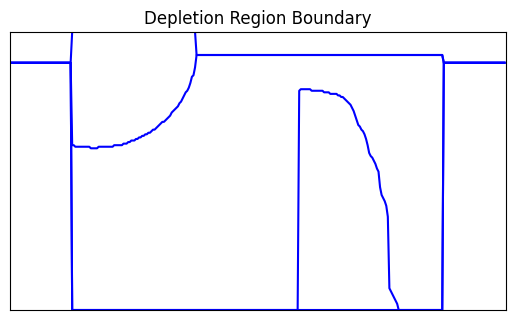

In [150]:
def plot_lines(conts):
    plt.ylim((0, 179))
    plt.xlim((0, total_width))
    plt.gca().set_aspect(1)
    plt.title("Depletion Region Boundary")
    plt.gca().axes.yaxis.set_visible(False)
    plt.gca().axes.xaxis.set_visible(False)
    lines_list = [ contour_to_lines(cont) for cont in conts ]
    for lines in lines_list:
        plt.plot(lines[0], color="blue")
        plt.plot(lines[1], color="blue")
    plt.show()
plot_lines(conts)